# In class exercises for 11.02.2020 (Filtering)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_brick_filt as mf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


## Like last week: extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [3]:
seg_data = data[:,(tx>=0)  & (tx<2000)]
seg_time = tx[(tx>=0) & (tx<2000)]

## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

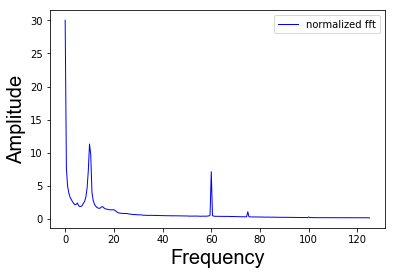

In [4]:
r,c = seg_data.shape

sp = np.fft.rfft(seg_data, axis=1)                    # compute FFT

# compute amplitude
amp = (np.abs(sp) / c) *2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial
* bonus: make the apply_filt function matrisized! pay attention to the dimension of the data you are passing into the fft function - you want to fft across time!

In [11]:
type_filt = 'lp'
cutoff = 20

# make our function call to generate a lp filter
lp_filt = mf.define_filt(fx=freq, filt_freq=cutoff, type_filt=type_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = mf.apply_filt(input_sig=seg_data[i,:], input_filter=lp_filt)

# or, for the matrix version...
filt_sig = mf.apply_filt_2D(input_sig=seg_data, input_filter=lp_filt)

(960, 251)


## Then FFT it again to see if you got rid of the hf components of the signal

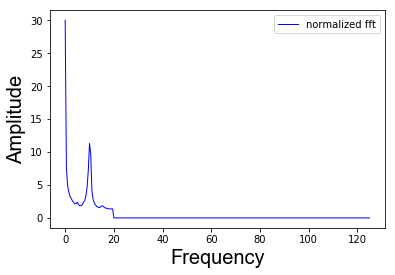

In [12]:
r,c = filt_sig.shape

# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter, then make a hp filter
* Then combine the two filters (multiply in frequ domain) 
* Then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

In [7]:
# figure out our lp and hp cutoffs given a desired band pass range
bp_range = [6, 14]

# first low pass...
type_filt = 'lp'

# make our function call to generate a lp filter
lp_filt = mf.define_filt(fx=freq, filt_freq=bp_range[0], type_filt=type_filt)

# then make a high pass filter...
type_filt = 'hp'

# make our function call to generate a hp filter
hp_filt = mf.define_filt(fx=freq, filt_freq=bp_range[1], type_filt=type_filt)

# now combine the filters (1 - sum of filters defined in the freq domain)
bp_filt = 1 - (lp_filt + hp_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = mf.apply_filt(input_sig=seg_data[i,:], input_filter=bp_filt)

## Then FFT and look at filtered signal in the time and frequency domains (time domain on one plot, and freq on the other)

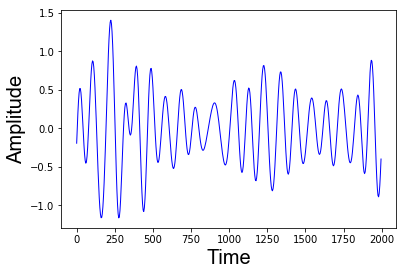

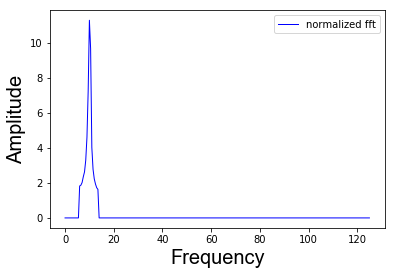

In [8]:
r,c = filt_sig.shape

# plot time domain sig
plt.plot(seg_time, np.mean(filt_sig, axis=0), 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.xlabel('Time', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()


# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

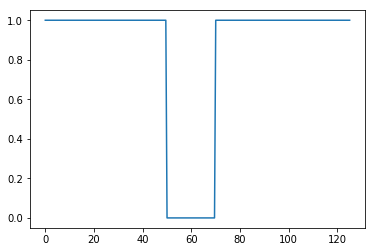

In [9]:
# figure out our lp and hp cutoffs given a desired band stop range
bp_range = [50,70]

# first low pass...
type_filt = 'lp'

# make our function call to generate a lp filter
lp_filt = mf.define_filt(fx=freq, filt_freq=bp_range[0], type_filt=type_filt)

# then make a high pass filter...
type_filt = 'hp'

# make our function call to generate a hp filter
hp_filt = mf.define_filt(fx=freq, filt_freq=bp_range[1], type_filt=type_filt)

# now combine the filters (add them in case)
bs_filt = (lp_filt + hp_filt) 

# check it!
plt.plot(freq, bs_filt)

# filter the signal
filt_sig = np.zeros((r,c))
for i in np.arange(r):
    filt_sig[i,:] = mf.apply_filt(input_sig=seg_data[i,:], input_filter=bs_filt)

## Then FFT and look at filtered signal in the frequency domain

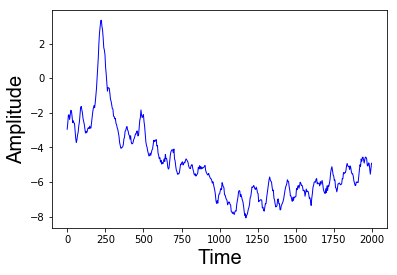

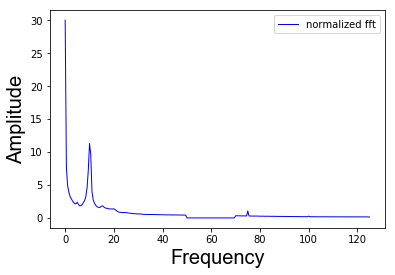

In [10]:
r,c = filt_sig.shape

# plot time domain sig
plt.plot(seg_time, np.mean(filt_sig, axis=0), 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.xlabel('Time', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()


# compute FFT - all trials at once
sp = np.fft.rfft(filt_sig, axis=1)                    

# compute amplitude
amp = (np.abs(sp) / c) * 2

mean_amp = np.mean(amp, axis=0)

# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg

plt.plot(freq, mean_amp, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)

plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency', **fig_font)
plt.ylabel('Amplitude', **fig_font)
plt.show()

# BONUS: Read the end of the tutorial and figure out to do this all more gracefully using blackman windowed filters :) 